# Segmentação usando redes neurais tipo C.N.N.

## Universidade de São Paulo - Escola Politécnica - PPGEE

**Disciplina: PTC5750 / 2017 - 3º Período**

**Docente Responsável: Sérgio Shiguemi Furuie**

Aluno: Fábio T. Sancinetti - N. USP: 10156476


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
import keras

from keras import backend as K
from keras import losses

from keras.models import Model, Sequential
from keras.objectives import categorical_crossentropy

from keras.layers import Input, concatenate
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Conv2DTranspose, ZeroPadding2D

from keras.optimizers import Adam, Adadelta, Adamax, Nadam, Adagrad, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback

from keras.initializers import RandomUniform, RandomNormal

Using TensorFlow backend.


In [3]:
class PatientData(object):
    """
    
    PatientData looks for files of 3DIRCAD database.
    This database contains DICOM files and data is split into folders.
    PATIENT_DICOM folder contains original original CT Images
    MASKS_DICOM contains a list of several folders. Each folder is named
    according to the organ highlighted in the masks of the files within.
    During PatientData initialization, it will look for the folder pointed at
    root_dir and will load files named with same name on MASKS_DICOM/<organ name>/*
    
    """
    def __init__(self, root_dir, oi, file_extension=".dcm"):
        import os, re
        
        patient_images = {}

        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith(file_extension):
                    if 'PATIENT_DICOM' in root:
                        if not patient_images.get(file,None):
                            patient_images[file] = {}
                        p = os.path.join(root,file)
                        patient_images[file]['real'] = p
                    elif 'MASKS_DICOM' in root:
                        if not patient_images.get(file,None):
                            patient_images[file] = {}
                        p = os.path.join(root,file)
                        rs = re.match('.*MASKS_DICOM/(.*)/.*', str(p))
                        patient_images[file][rs.groups()[0]] = p

        self.oi = oi
        self.X = []
        self.Y = []
        
        for k,v in patient_images.items():
            for k1,v1 in v.items():
                if k1 == self.oi:
                    self.X.append(v['real'])
                    self.Y.append(v1)
        
        if len(self.X) != len(self.Y):
            raise Exception("number of input images (%d) does not match number of training samples (%d)" % 
                            (len(self.X),len(self.Y)))
   
            
    def normalize(self, img):
        arr = img.copy().astype(np.float)
        M = np.float(np.max(img))
        if M != 0:
            arr *= 1./M
        return arr
    

    def add_gauss_noise(self, inp, expected_noise_ratio=0.05):
        image = inp.copy()
        if len(image.shape) == 2:
            row,col= image.shape
            ch = 1
        else:
            row,col,ch= image.shape
        mean = 0.
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col)) * expected_noise_ratio
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy

    def get_data(self, noisy=False, split_part=0.5, resize_side=None, verbose=False):
        from scipy.ndimage.interpolation import zoom        
        from random import shuffle
        import dicom
        
        im_X = []
        im_Y = []
        for i in range(len(self.X)):
            img_x = dicom.read_file(self.X[i]).pixel_array
            img_y = dicom.read_file(self.Y[i]).pixel_array
            if resize_side != None:
                ratio = resize_side / 512.
                img_x = zoom(img_x, ratio).copy()
                img_y = zoom(img_y, ratio).copy()
            img_x = self.normalize(img_x)
            img_y = self.normalize(img_y)

            if np.sum(img_y) < 5.:
                if np.random.randint(1,10) <= 5:
                    if verbose:
                        print("discarding a very zero like image %s (%f)" % (self.Y[i],np.sum(img_y)))
                    continue
            if noisy:
                img_x = self.add_gauss_noise(img_x)
                img_y = self.add_gauss_noise(img_y)
            im_X.append(img_x)
            im_Y.append(img_y)
            
        train_limit = int(len(im_X)*split_part)

        indexes = list(range(len(im_X)))
        shuffle(indexes)            

        shuffleX = [im_X[c] for c in indexes]
        shuffleY = [im_Y[c] for c in indexes]

        train_x = shuffleX[0:train_limit]
        test_x = shuffleX[train_limit:]
        train_y = shuffleY[0:train_limit]
        test_y = shuffleY[train_limit:]
        
        return train_x, train_y, test_x, test_y 
        

In [4]:
root_dir = "/home/fox/workspace/scipy/projects/dicom/ircad/"

In [5]:
sample_height, sample_width = (128,128)
output_width, output_height = (128, 128)
img_tot_size = sample_width*sample_height

In [6]:
sess = tf.Session()
K.set_session(sess)

In [7]:
pd = PatientData(root_dir, 'liver') # Also works for 'liver'

In [8]:
data = pd.get_data(False, 0.75, sample_width) # Using 75% for training
train_x, train_y, test_x, test_y = map(np.array, data)
print("Using %s images for training and %s images for testing" % (len(train_x), len(test_x)))

Using 182 images for training and 61 images for testing


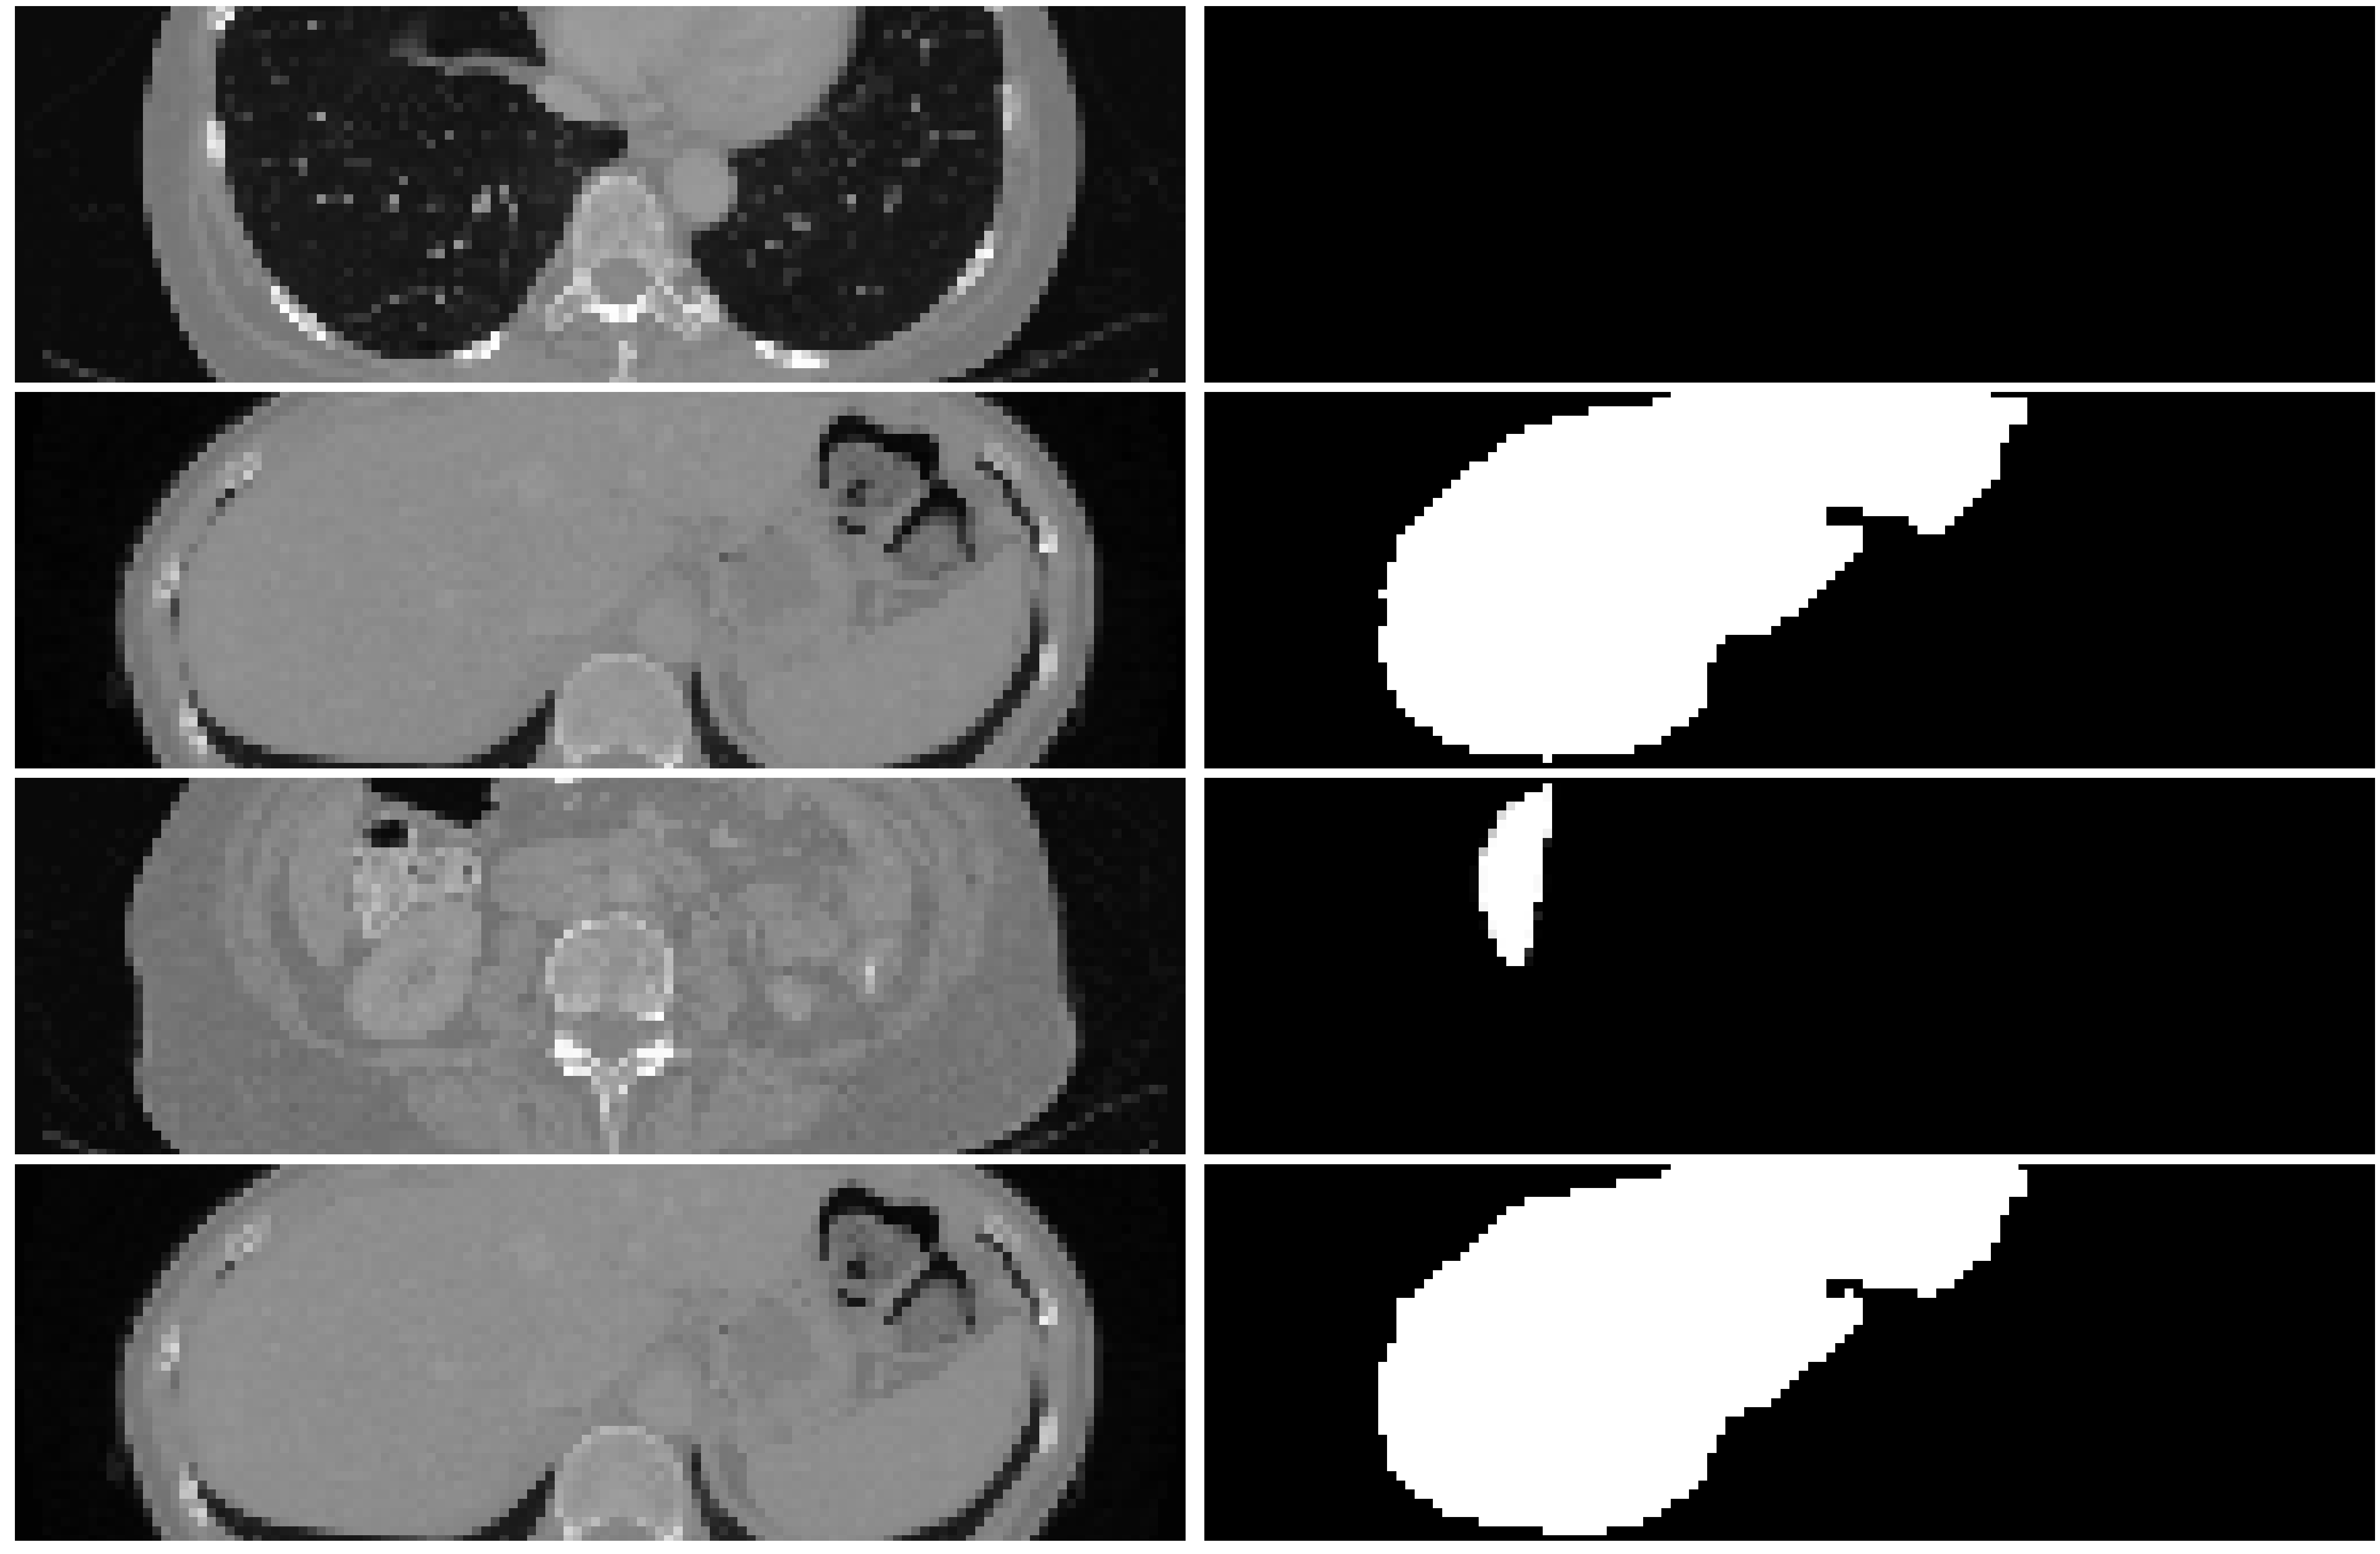

In [9]:
# Displaying some samples of the input
lines = min(4,len(train_x)) # len(imgs_mask_test) #16
fig, axarr = plt.subplots(lines, 2, figsize=(60,lines*10), sharex=True, sharey=False)

tot_dice = 0.
for i in range(0,lines):
    
    axarr[i,0].imshow(train_x[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,1].imshow(train_y[i].reshape(output_width, output_height), cmap='gray')
    
    for x in range(2):
        axarr[i,x].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.975)
plt.show()

In [10]:
train_x = np.array([t.reshape(sample_width, sample_height,1) for t in train_x])
train_y = np.array([t.reshape(sample_width, sample_height,1) for t in train_y])
test_x  = np.array([t.reshape(sample_width, sample_height,1) for t in test_x])
test_y  = np.array([t.reshape(sample_width, sample_height,1) for t in test_y])

In [11]:
class ObserveTrainingFailure(Callback):
    """
    
    ObserveTrainingFailure is a callback that automaticaly kicks obvious local minima responses.
    It has been designed to work with dice coeficient, but it could be used with other types of
    error observances, such as Binary Cross entropy.
    
    observable : variable to be observed within the received tensor from callback
    patience   : Number of consecutive times this callback will allow the training to
                 miserably fails. If it is -1 it will not interrupt the training
    trials     : number of times this callback will wait for training to get out of
                 failure or stagnation out of target zone
    target     : it will define a zone which is 'close enough' from the solution.
                 When training reaches this region, it will start to work with
                 learning rate (1) checking if current rate is too big and then
                 (2) if current rate is too small.
    
    This class is not a optimal solution. The best way would be correctly parameterize each
    model optimizer. But for practical purposes and save some time, this suboptimal solution
    works in the proposed studying context.
    
    """
    def __init__(self, observable='dice_coef', op='max', patience=-1, trials=5, target=None, verbose=False):
        super(Callback, self).__init__()
        self.patience = patience
        self.start_patience = patience
        self.wait = 0
        self.trials = trials
        if op == 'min':
            if not target :
                self.target = 0.03
            self.best_score = float("inf")
        else:
            if not target :
                self.target = 0.8
            self.best_score = 0.
        self.verbose = verbose
        self.observable = observable
        self.op = op
        self.lr_reds = 0
        self.lr_ups = 0

    def check_better(self, previous, current):
        if self.verbose:
            print("\nop %s previous %f current %f" % (self.op,previous,current))
        if self.op == 'min':
            return (current < previous)
        else:
            return current > previous
        
    def on_epoch_end(self, epoch, logs={}):
        current_score = logs.get(self.observable)
        if current_score == None:
            if self.op == 'min':
                current_score = float("inf")
            else:
                current_score = 0.
        if self.check_better(self.best_score, current_score):
            if self.verbose:
                print("\nnew result is better")
            self.best_score = current_score
            self.wait = 0
            self.patience = self.start_patience
            
            if self.verbose > 0:
                print('\n best = %.3f\n' % current_score)
        else:
            if self.verbose:
                print("\nnew result is worst")
            if self.check_better(current_score, self.target):
                if self.wait >= self.trials:
                    session = K.get_session()
                    for layer in self.model.layers: 
                        for v in layer.__dict__:
                            v_arg = getattr(layer,v)
                            if hasattr(v_arg,'initializer'):
                                initializer_method = getattr(v_arg, 'initializer')
                                initializer_method.run(session=session)
                                if self.verbose:
                                    print(' reinitializing layer {}.{}'.format(layer.name, v))
                    self.wait = 0
                else:
                    self.wait += 1
                    self.patience -=1
                    if self.patience == 0:
                        if self.verbose:
                            print("\n early stopping on %d\n" % (epoch))
                        self.model.stop_training = True
            else:
                lr = float(K.get_value(self.model.optimizer.lr))
                
                max_changes = 5
                reduce_rate = 0.5
                chg = ''
                if (self.lr_ups > max_changes or self.lr_reds <= max_changes) and lr > 0.:
                    chg = 'reduce'
                    K.set_value(self.model.optimizer.lr, lr * reduce_rate)
                    self.lr_ups = 0
                    self.lr_reds += 1
                else:
                    chg = 'increase'
                    if lr == 0:
                        lr = 1e-4
                    else:
                        if self.lr_ups == 0:
                            K.set_value(self.model.optimizer.lr, lr * (1./reduce_rate)**(max_changes+1) )
                        else:
                            K.set_value(self.model.optimizer.lr, lr * (1./reduce_rate) )
                    self.lr_ups += 1
                    self.lr_reds = 0
                
                lr = float(K.get_value(self.model.optimizer.lr))
                if self.verbose:
                    print('\n near target, %s LR to :' % (chg,), lr)  
        

In [12]:
def get_model(optimizer, loss_metric, metrics, lr=1e-3):
    inputs = Input((sample_width, sample_height, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.3)(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.3)(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # working with dice and adam
    model.compile(optimizer=optimizer(lr=lr), loss=loss_metric, metrics=metrics)
    
    # Binary Crossentropy works well in general
    #model.compile(loss=losses.binary_crossentropy, optimizer=Adam(lr=lr))
    
    # Adagrad and dice with new reducer works, but it very slow. Reached 0.8 on dice score only after 200 iterations
    #model.compile(optimizer=Adagrad(lr=lr), loss=dice_coef_loss, metrics=[dice_coef])
    
    # SGD (Stochastic Gradient Descent) works both with dice and binary crossentropy But it takes too many iterations.
    # During tests it reached a 0.7 score after 200 hundred iterations. It was continuosly improving, but very slowly.
    # Learning rate has to be set to 0.1. If less than this, it will continously stuck on local solution.
    
    #model.compile(optimizer=SGD(lr=lr), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=SGD(lr=lr), loss=losses.binary_crossentropy)    
    
    # Adadelta (lr=1e-1) performance very similar with SGD
    #model.compile(optimizer=Adadelta(lr=lr), loss=dice_coef_loss, metrics=[dice_coef])
    
    # Adamax and Adagrad also works similar to Adam
    # Adadelta and Nadam stuck on local minima too many times, no reasonable results were found
    # RMSPprop has totally failed. It didn't improve much from the initiated values

    return model

In [13]:
smooth = 1.

# Dice Coefficient to work with Tensorflow
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Dice Coefficient to work outside Tensorflow
def dice_coef_2(y_true, y_pred):
    side = len(y_true[0])
    y_true_f = y_true.reshape(side*side)
    y_pred_f = y_pred.reshape(side*side)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)
    

In [14]:
model = get_model(optimizer=Adam, loss_metric=dice_coef_loss, metrics=[dice_coef], lr=1e-3)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
observe_var = 'dice_coef'
strategy = 'max' # greater dice_coef is better

#observe_var = 'loss' # for binary crossentropy 
#strategy = 'in' # smallest loss is better

model_checkpoint = ModelCheckpoint('ptc5750.h5', monitor=observe_var, save_best_only=True)
model_reset = ObserveTrainingFailure(observe_var,strategy, -1 , 10)



In [16]:
model.fit(train_x, train_y, batch_size=int(len(train_x)/4),
          epochs=250, verbose=1, shuffle=True, validation_split=0.2,
         callbacks=[model_checkpoint, model_reset])

Train on 145 samples, validate on 37 samples
Epoch 1/250
145/145 [==============================] - 5s 33ms/step - loss: -0.1088 - dice_coef: 0.1088 - val_loss: -0.1597 - val_dice_coef: 0.1597
Epoch 2/250
145/145 [==============================] - 1s 7ms/step - loss: -0.1490 - dice_coef: 0.1490 - val_loss: -0.0800 - val_dice_coef: 0.0800
Epoch 3/250
145/145 [==============================] - 1s 7ms/step - loss: -0.0990 - dice_coef: 0.0990 - val_loss: -0.3922 - val_dice_coef: 0.3922
Epoch 4/250
145/145 [==============================] - 1s 6ms/step - loss: -0.3757 - dice_coef: 0.3757 - val_loss: -0.4021 - val_dice_coef: 0.4021
Epoch 5/250
145/145 [==============================] - 1s 6ms/step - loss: -0.3978 - dice_coef: 0.3978 - val_loss: -0.4455 - val_dice_coef: 0.4455
Epoch 6/250
145/145 [==============================] - 1s 6ms/step - loss: -0.4644 - dice_coef: 0.4644 - val_loss: -0.5915 - val_dice_coef: 0.5915
Epoch 7/250
145/145 [==============================] - 1s 6ms/step - los

145/145 [==============================] - 1s 6ms/step - loss: -0.9402 - dice_coef: 0.9402 - val_loss: -0.9508 - val_dice_coef: 0.9508
Epoch 57/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9391 - dice_coef: 0.9391 - val_loss: -0.9523 - val_dice_coef: 0.9523
Epoch 58/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9381 - dice_coef: 0.9381 - val_loss: -0.9420 - val_dice_coef: 0.9420
Epoch 59/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9382 - dice_coef: 0.9382 - val_loss: -0.9529 - val_dice_coef: 0.9529
Epoch 60/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9443 - dice_coef: 0.9443 - val_loss: -0.9470 - val_dice_coef: 0.9470
Epoch 61/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9414 - dice_coef: 0.9414 - val_loss: -0.9517 - val_dice_coef: 0.9517
Epoch 62/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9432 - dice_coef: 0.9432 - val_loss: -0.9559 -

145/145 [==============================] - 1s 6ms/step - loss: -0.9508 - dice_coef: 0.9508 - val_loss: -0.9643 - val_dice_coef: 0.9643
Epoch 112/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9500 - dice_coef: 0.9500 - val_loss: -0.9620 - val_dice_coef: 0.9620
Epoch 113/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9539 - dice_coef: 0.9539 - val_loss: -0.9645 - val_dice_coef: 0.9645
Epoch 114/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9555 - dice_coef: 0.9555 - val_loss: -0.9653 - val_dice_coef: 0.9653
Epoch 115/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9554 - dice_coef: 0.9554 - val_loss: -0.9659 - val_dice_coef: 0.9659
Epoch 116/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9544 - dice_coef: 0.9544 - val_loss: -0.9659 - val_dice_coef: 0.9659
Epoch 117/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9557 - dice_coef: 0.9557 - val_loss: -0.

145/145 [==============================] - 1s 6ms/step - loss: -0.9627 - dice_coef: 0.9627 - val_loss: -0.9724 - val_dice_coef: 0.9724
Epoch 167/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9497 - dice_coef: 0.9497 - val_loss: -0.9635 - val_dice_coef: 0.9635
Epoch 168/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9490 - dice_coef: 0.9490 - val_loss: -0.9575 - val_dice_coef: 0.9575
Epoch 169/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9552 - dice_coef: 0.9552 - val_loss: -0.9711 - val_dice_coef: 0.9711
Epoch 170/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9548 - dice_coef: 0.9548 - val_loss: -0.9714 - val_dice_coef: 0.9714
Epoch 171/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9596 - dice_coef: 0.9596 - val_loss: -0.9691 - val_dice_coef: 0.9691
Epoch 172/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9602 - dice_coef: 0.9602 - val_loss: -0.

145/145 [==============================] - 1s 6ms/step - loss: -0.9618 - dice_coef: 0.9618 - val_loss: -0.9737 - val_dice_coef: 0.9737
Epoch 222/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9636 - dice_coef: 0.9636 - val_loss: -0.9744 - val_dice_coef: 0.9744
Epoch 223/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9650 - dice_coef: 0.9650 - val_loss: -0.9747 - val_dice_coef: 0.9747
Epoch 224/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9649 - dice_coef: 0.9649 - val_loss: -0.9749 - val_dice_coef: 0.9749
Epoch 225/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9611 - dice_coef: 0.9611 - val_loss: -0.9670 - val_dice_coef: 0.9670
Epoch 226/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9592 - dice_coef: 0.9592 - val_loss: -0.9738 - val_dice_coef: 0.9738
Epoch 227/250
145/145 [==============================] - 1s 6ms/step - loss: -0.9631 - dice_coef: 0.9631 - val_loss: -0.

In [17]:
imgs_mask_test = model.predict(test_x, verbose=1)

tot_dice = 0.
dices = []
for i in range(len(imgs_mask_test)):
    r = dice_coef_2(test_y[i],imgs_mask_test[i])
    dices.append(r)
    tot_dice += r
    
avg_dice = tot_dice/float(len(imgs_mask_test))
print(avg_dice)

61/61 [==============================] - 1s 13ms/step
0.947462544515


In [18]:

postProcess = True
if postProcess:        
    avg = np.average(imgs_mask_test)
    for k in range(len(imgs_mask_test)):
        im = imgs_mask_test[k]
        m = np.max(im)
        for i in range(len(im)):
            for j in range(len(im[i])):
                # remove low confidence results helps to increase dice result
                if im[i,j] < (0.5):
                    im[i,j] = 0.
    
    tot_dice = 0.
    dices = []
    for i in range(len(imgs_mask_test)):
        r = dice_coef_2(test_y[i],imgs_mask_test[i])
        dices.append(r)
        tot_dice += r
        

    avg_dice = tot_dice/float(len(imgs_mask_test))
    print(avg_dice)
                    

0.948166502598


In [19]:
# Displaying some results
lines = max(15,len(imgs_mask_test))
fig, axarr = plt.subplots(lines, 3, figsize=(60,lines*10), sharex=True, sharey=False)

output_width, output_height = (128, 128)
for i in range(0,lines):
    axarr[i,0].imshow(test_x[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,1].imshow(test_y[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,2].imshow(imgs_mask_test[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,2].set_title('Dice Coef = ' + str(dices[i]),fontsize=45,ha='center')
    
    for x in range(3):
        axarr[i,x].axis('off')

fig.suptitle('Dice average = ' + str(avg_dice) ,fontsize=60)
fig.tight_layout()
fig.subplots_adjust(top=0.975)
plt.show()